# Quasar cloning

### Time to get your hands dirty! Cloning quasars

Let's look at the redshift distributions of the quasars in the Sloan Digital Sky Survey.

The Sloan Digital Sky Survey or SDSS is a major multi-spectral imaging and spectroscopic redshift survey using a dedicated 2.5-m wide-angle optical telescope at Apache Point Observatory in New Mexico, United States. Operations started in 1998.

In phase 1, SDSS has released photometry data 357 million (!!!) unique sources and 1.6 million spectra. In phase 2, SDSS observed the same patch of the sky many times ("time domain astronomy", and now we're going to have LSST!)

Download the SDSS quasara data

- Upsample this distribution in two ways, using both rejection sampling and inverse transform.
- Check, at least visually, that the two cloned distribitions are indeed similar to the observed one (for a quantitative check, come back to this point in a few lectures)

(Hint: `scipy.stats` is your best friend)

- Think about the cosmology of quasars. How do you think they are distributed? Overplot the theorethical distribution to the measured SDSS data 

(Hint: `astropy.cosmology` is another close friend). The best-fit cosmological model from the Plack data is:

In [1]:
import numpy as np
import numpy.random as rd
import scipy.stats as sp
from astroML.datasets import fetch_dr7_quasar
import scipy.optimize as so
import matplotlib.pyplot as plt
import astropy

In [2]:
# Fetch the quasar data
data = fetch_dr7_quasar()

# select the first 10000 points
data = data[:10000]
 
z = data['redshift']

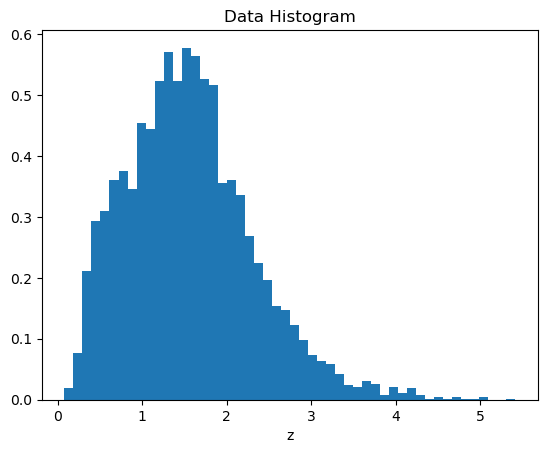

In [3]:
z_hist = plt.hist(z, bins=50, density = True)
plt.title('Data Histogram')
plt.xlabel('z')

z_1 = np.linspace(z.min(), z.max(), 35000) # 35000 to an almost perfect match
h_hist = np.random.uniform(0, z_hist[0].max(), 35000) # In z_hist[0] there are the heights of the bins 

## Rejection Sampling
I try with a self-implementation comparing manually each height of the bins

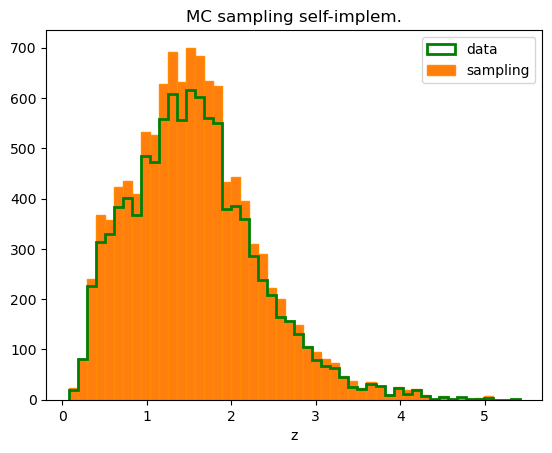

In [6]:
# Heights of the new histogram of generated samples
new_histo_z = np.zeros(50)

# Cycle to select the bins to compare with during Monte Carlo sampling
for i in range(len(z_hist[1]) - 1):
    
     for j in range(len(z_1)):
         if z_1[j] >= z_hist[1][i] and z_1[j] < z_hist[1][i+1]:
             if h_hist[j] < z_hist[0][i]:
                 new_histo_z[i] += 1
    
# Binning of the new histogram
binning = []
differences = np.diff(z_hist[1])

for i in range(50):
    binning.append(differences[i]/2 + z_hist[1][i])

yzhist = plt.hist(z, bins=50, color='green', histtype='step', lw = 2, label = 'data')
plt.bar(binning, new_histo_z, width = differences, edgecolor = 'darkorange', label = 'sampling')
plt.title('MC sampling self-implem.')
plt.xlabel('z')
plt.legend()
plt.show()

Now I can try with the implementation of scipy, first I see how the method works 

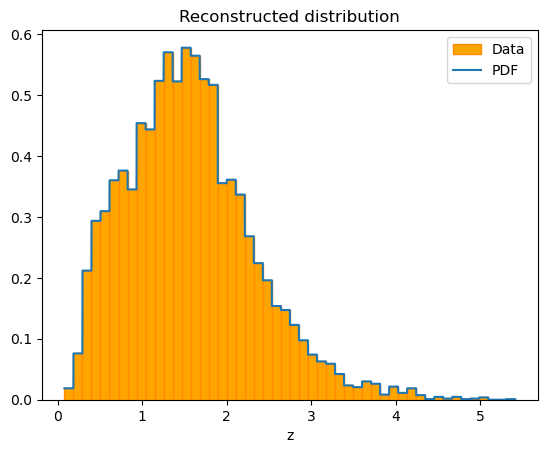

In [10]:
dist_hist = sp.rv_histogram(z_hist[:2])
z_hist = plt.hist(z, bins = 50, density = True, edgecolor = 'darkorange', color = 'Orange', label = 'Data')
plt.plot(z_1, dist_hist.pdf(z_1), label = 'PDF')

plt.title('Reconstructed distribution')
plt.legend()
plt.xlabel('z')
plt.show()

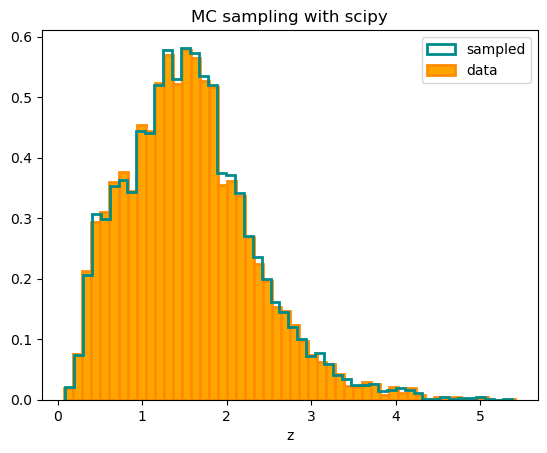

In [12]:

sampled_data = z_1[h_hist < dist_hist.pdf(z_1)]

plt.hist(sampled_data, bins = 50, color = 'darkcyan', histtype = 'step', label = 'sampled', lw = 2, density = True)
y_hist = plt.hist(z, bins = 50, color = 'Orange', edgecolor = 'darkorange', lw = 2, label = 'data', density = True)
plt.title('MC sampling with scipy')
plt.xlabel('z')
plt.legend()
plt.show()

## Inverse sampling

To provide the samples in this case, I can find the cdf from the data and invert it manually to take the samples. Another possible way is to take directly the ppf function: it gives the value of the data fixed the probability

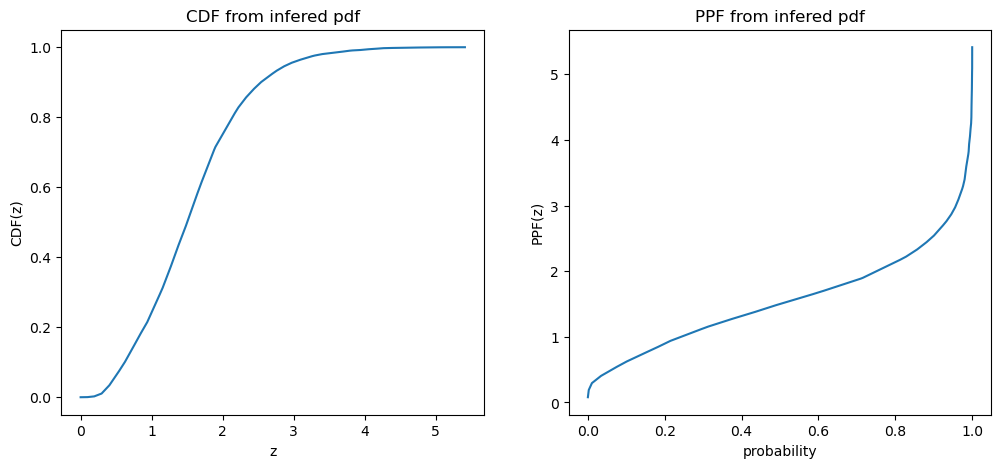

In [16]:
y_random = np.random.uniform(0, 1, 11000)
x = np.linspace(0, z.max(), 10000)
x_prob = np.linspace(0, 1, 10000)
fig = plt.figure(figsize = (12,5))

ax = fig.add_subplot(121)
ax.plot(x, dist_hist.cdf(x))
plt.title('CDF from infered pdf')
plt.xlabel('z')
plt.ylabel('CDF(z)')


ax = fig.add_subplot(122)
ax.plot(x_prob, dist_hist.ppf(x_prob))
plt.title('PPF from infered pdf')
plt.xlabel('probability')
plt.ylabel('PPF(z)')

plt.show()



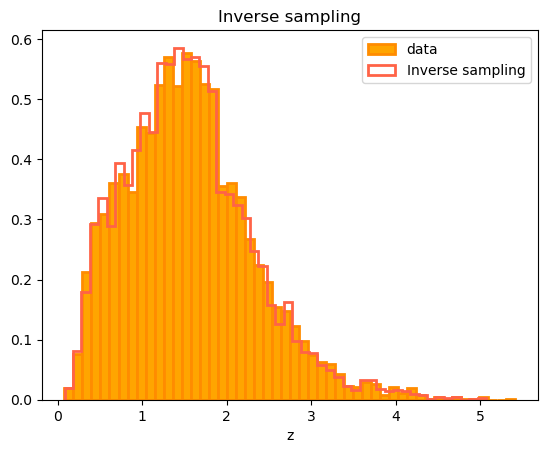

In [17]:
prob_sample = np.random.uniform(0, 1, 10000)
inv_samples = dist_hist.ppf(prob_sample)

hz = plt.hist(z, bins = 50,  color = 'Orange', edgecolor = 'darkorange', lw = 2, density = True, label = 'data')
inv_histo = plt.hist(inv_samples, bins = 50, density = True, histtype = 'step', color = 'red', edgecolor = 'tomato', lw = 2, label = 'Inverse sampling')
plt.title('Inverse sampling')
plt.xlabel('z')
plt.legend()
plt.show()

This is just a manual inversion of CDF

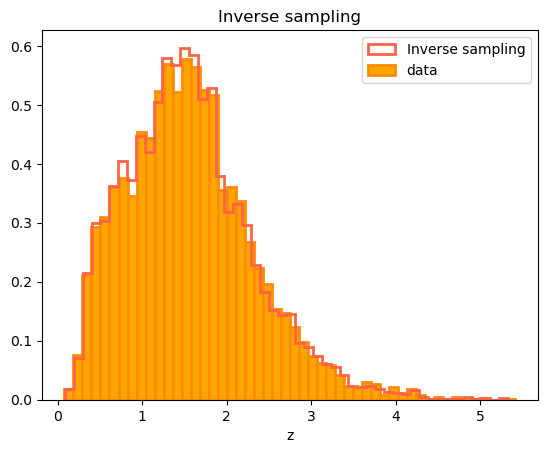

In [21]:
samples = [so.brentq(lambda x: dist_hist.cdf(x) - e, 0, 10) for e in y_random]

plt.hist(samples, bins = 50, density = True, histtype = 'step', color = 'red', edgecolor = 'tomato', lw = 2, label = 'Inverse sampling')

xv = np.linspace(0,6,100)
hz = plt.hist(z, bins = 50,  color = 'Orange', edgecolor = 'darkorange', lw = 2, density = True, label = 'data')
plt.title('Inverse sampling')
plt.xlabel('z')
plt.legend()
plt.show()

# Cosmology

We know the expected quasar distribution from Cosmology, we can get the model from astropy

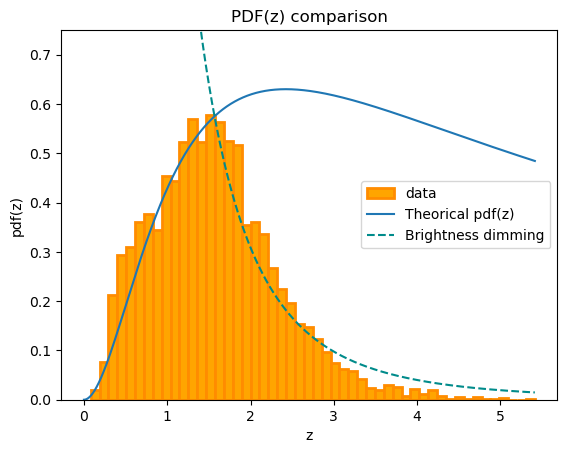

In [30]:
P_cosmology = astropy.cosmology.Planck18

dist = P_cosmology.differential_comoving_volume(x).value
dist = dist/(sum(dist)) 

hz = plt.hist(z, bins = 50,  color = 'Orange', edgecolor = 'darkorange', lw = 2, density = True, label = 'data')
plt.plot(x, 1e4/2 * dist, label = 'Theorical pdf(z)') 
plt.plot(x, 25/(1 + x)**4, label = 'Brightness dimming', c = 'darkcyan', ls = '--')
plt.xlabel('z')
plt.ylim(0, 0.75)
plt.ylabel('pdf(z)')
plt.title('PDF(z) comparison')
plt.legend();

### Experiment:
Here I try a Brightness dimming model: the brightness of the Quasar, due to the expansion of the universe should drop as: $$ I \simeq \frac{I_0}{(1+z)^4}$$
Maybe this discrepancy is just a selection effect due to the Brightness Dimming? 

It's seems fine the match with the last part, it must be combined with the model maybe...

# Bonus: KS Test

If the p-value is small (< 0.05 conventionally), I can reject the null hypotesis. 


It could be: are the two samples drawn from the same distribution? 


More direct: does my sampling technique work well?


In [42]:
Ks_test_MC = sp.ks_2samp(z, sampled_data)
Ks_test_scipy = sp.ks_2samp(z, inv_samples)

print('Ks distance for MC sampling: ', Ks_test_MC.statistic)
print('p-value for MC sampling: ', Ks_test_MC.pvalue)
print('Ks distance for inverse sampling: ', Ks_test_scipy.statistic)
print('p-value for inverse sampling: ', Ks_test_scipy.pvalue)


Ks distance for MC sampling:  0.007312649270234395
p-value for MC sampling:  0.9371335674556948
Ks distance for inverse sampling:  0.0066
p-value for inverse sampling:  0.9813865022115018


The p-values are quite high and kS distances low, this means that the samples
are drawn correctly from the same distribution of the data.